In [1]:
from matplotlib import pyplot as plt
import os
import numpy as np
%matplotlib inline
from matplotlib.offsetbox import AnchoredText
from DSOhelper import addsubfiglabels,get_oscilloscope_data,getvoltage,plot_scope_data,subplot_scope_data

In [2]:
from scipy.signal import find_peaks

## determine the mean height of peaks vs overvoltage

In [3]:
datafolder = "vary_led_1562/"
files = sorted(os.listdir(datafolder))
file=files[0]
files

['temp0000000.CSV',
 'temp0000001.CSV',
 'temp0000002.CSV',
 'temp0000003.CSV',
 'temp0000004.CSV',
 'temp0000005.CSV',
 'temp0000006.CSV',
 'temp0000007.CSV',
 'temp0000008.CSV',
 'temp0000009.CSV',
 'temp0000010.CSV',
 'temp0000011.CSV',
 'temp0000012.CSV',
 'temp0000013.CSV',
 'temp0000014.CSV',
 'temp0000015.CSV',
 'temp0000016.CSV',
 'temp0000017.CSV',
 'temp0000018.CSV',
 'temp0000019.CSV',
 'temp0000020.CSV',
 'temp0000021.CSV',
 'temp0000022.CSV',
 'temp0000023.CSV',
 'temp0000024.CSV',
 'temp0000025.CSV',
 'temp0000026.CSV',
 'temp0000027.CSV',
 'temp0000028.CSV',
 'temp0000029.CSV',
 'temp0000030.CSV',
 'temp0000031.CSV',
 'temp0000032.CSV',
 'temp0000033.CSV',
 'temp0000034.CSV',
 'temp0000035.CSV',
 'temp0000036.CSV',
 'temp0000037.CSV',
 'temp0000038.CSV',
 'temp0000039.CSV',
 'temp0000040.CSV',
 'temp0000041.CSV',
 'temp0000042.CSV',
 'temp0000043.CSV',
 'temp0000044.CSV',
 'temp0000045.CSV',
 'temp0000046.CSV',
 'temp0000047.CSV',
 'temp0000048.CSV',
 'temp0000049.CSV',


In [4]:
dataseq,headers=get_oscilloscope_data(f"{datafolder}{file}")

In [5]:
headers

{1: {'Memory Length': 10000.0,
  'IntpDistance': 0.0,
  'Trigger Address': 5159.0,
  'Trigger Level': 0.3,
  'Source': 'CH1',
  'Vertical Units': 'V',
  'Vertical Units Div': 0.0,
  'Vertical Units Extend Div': 16.0,
  'Label': '',
  'Probe Type': 0.0,
  'Probe Ratio': 10.0,
  'Vertical Scale': 0.5,
  'Vertical Position': -1.78,
  'Horizontal Units': 'S',
  'Horizontal Scale': 2e-05,
  'Horizontal Position': -3.2e-06,
  'Horizontal Mode': 'Main',
  'SincET Mode': 'Real Time',
  'Sampling Period': 2e-08,
  'Horizontal Old Scale': 2e-05,
  'Horizontal Old Position': -3.2e-06,
  'Firmware': 'V1.23',
  'Mode': 'Fast'},
 2: {'Memory Length': 10000.0,
  'IntpDistance': 0.0,
  'Trigger Address': 5159.0,
  'Trigger Level': 0.3,
  'Source': 'CH2',
  'Vertical Units': 'V',
  'Vertical Units Div': 0.0,
  'Vertical Units Extend Div': 16.0,
  'Label': '',
  'Probe Type': 0.0,
  'Probe Ratio': 1.0,
  'Vertical Scale': 0.2,
  'Vertical Position': -2.24,
  'Horizontal Units': 'S',
  'Horizontal Scale'

In [6]:
headers[1]["Sampling Period"],headers[1]["Vertical Scale"]

(2e-08, 0.5)

### plotting a subset of data for sanity check

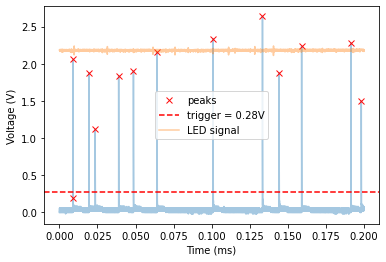

In [39]:
zeroOverVoltage = 139.3
CH=1
fig,ax = plt.subplots()
dataseq,headers=get_oscilloscope_data(f"{datafolder}{'temq0001505.CSV'}")
xscale=1e3
subplot_scope_data(dataseq,headers,ax,alpha=0.4,xscale=xscale) 
peak_x , peak_heights = find_peaks(dataseq[CH],height=10)
ax.plot(peak_x*headers[CH]["Sampling Period"]*xscale,getvoltage(peak_heights["peak_heights"],headers[CH]),"x",c="r",alpha=0.96,label="peaks")
ax.axhline(headers[CH]["Trigger Level"],c="r",ls="--",label=f"trigger = {headers[CH]['Trigger Level']}V")
subplot_scope_data(dataseq,headers,ax,CH=2,alpha=0.4,xscale=xscale,label="LED signal")
ax.legend()
ax.set_ylabel("Voltage (V)")
ax.set_xlabel("Time (ms)")
plt.show()

In [29]:
%%time
average_led_voltage=[]
for file in files[::50]:
    dataseq,headers=get_oscilloscope_data(f"{datafolder}{file}")
    average_led_voltage.append(np.mean(getvoltage(dataseq[2],headers[2])))

Wall time: 6.4 s


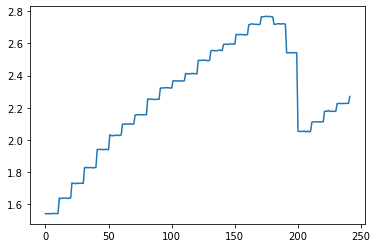

In [30]:
plt.plot(average_led_voltage)

In [31]:
headers

{1: {'Memory Length': 10000.0,
  'IntpDistance': 0.0,
  'Trigger Address': 5049.0,
  'Trigger Level': 0.28,
  'Source': 'CH1',
  'Vertical Units': 'V',
  'Vertical Units Div': 0.0,
  'Vertical Units Extend Div': 16.0,
  'Label': '',
  'Probe Type': 0.0,
  'Probe Ratio': 10.0,
  'Vertical Scale': 0.5,
  'Vertical Position': -1.78,
  'Horizontal Units': 'S',
  'Horizontal Scale': 2e-05,
  'Horizontal Position': -1e-06,
  'Horizontal Mode': 'Main',
  'SincET Mode': 'Real Time',
  'Sampling Period': 2e-08,
  'Horizontal Old Scale': 2e-05,
  'Horizontal Old Position': -1e-06,
  'Firmware': 'V1.23',
  'Mode': 'Fast'},
 2: {'Memory Length': 10000.0,
  'IntpDistance': 0.0,
  'Trigger Address': 5049.0,
  'Trigger Level': 0.28,
  'Source': 'CH2',
  'Vertical Units': 'V',
  'Vertical Units Div': 0.0,
  'Vertical Units Extend Div': 16.0,
  'Label': '',
  'Probe Type': 0.0,
  'Probe Ratio': 1.0,
  'Vertical Scale': 0.2,
  'Vertical Position': -2.24,
  'Horizontal Units': 'S',
  'Horizontal Scale': 